In [24]:
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot

In [25]:
import cv2
from numpy import savez_compressed

In [26]:
def load_images(data_path, lr_size=(32, 32), hr_size=(128, 128)):
    low_resolution_images, high_resolution_images = list(), list()

    for IMAGE in tqdm(os.listdir(data_path)):
        if IMAGE == '.DS_Store':
            continue
        image_path = os.path.join(data_path, IMAGE)
        image = cv2.imread(image_path)

        low_res = cv2.resize(image, lr_size)
        high_res = cv2.resize(image, hr_size)

        low_resolution_images.append(low_res)
        high_resolution_images.append(high_res)

    return np.array(low_resolution_images), np.array(high_resolution_images)

In [27]:
data_path = '/Applications/ML projects/Failures/Super Resolution/high res'
low_resolution_images, high_resolution_images = load_images(data_path)
file = 'imgs_32_128.npz'
savez_compressed(file, low_resolution_images, high_resolution_images)
print('Saved dataset: ', file)

100%|██████████| 1255/1255 [00:35<00:00, 34.93it/s]


Saved dataset:  imgs_32_128.npz


In [28]:
dataset = np.load('imgs_32_128.npz')
low_resolution_images, high_resolution_images = dataset['arr_0'], dataset['arr_1']
print('Loaded: ', low_resolution_images.shape, high_resolution_images.shape)

Loaded:  (1254, 32, 32, 3) (1254, 128, 128, 3)


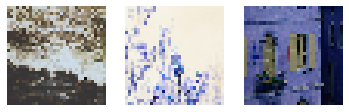

In [29]:
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(1, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(low_resolution_images[i].astype('uint8'))

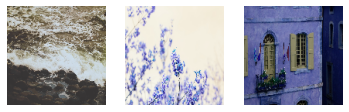

In [30]:
for i in range(n_samples):
    pyplot.subplot(1, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(high_resolution_images[i].astype('uint8'))

In [31]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, PReLU, Dense, Flatten, Activation, Add, UpSampling2D

In [32]:
def residual_block(input):
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(input)
    x = BatchNormalization(momentum=0.5)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    output = Add()([input, x])
    return output

In [33]:
def upsample_block(input):
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same')(input)
    x = UpSampling2D(size=2)(x)
    output = PReLU(shared_axes=[1, 2])(x)
    return output

In [34]:
def generator(num_res_blocks=16, num_up_blocks=2, input_size=(32, 32, 3)):
    input = Input(shape=input_size)

    x = Conv2D(filters=64, kernel_size=(9, 9), strides=1, padding='same')(input)
    x = skip_connection = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = Add()([x, skip_connection])

    for _ in range(num_up_blocks):
        x = upsample_block(x)

    output = Conv2D(filters=3, kernel_size=(9, 9), strides=1, padding='same')(x)
    model = Model(input, output)
    return model

In [35]:
generator_model = generator()
generator_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 64)   15616       ['input_4[0][0]']                
                                                                                                  
 p_re_lu_19 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_19[0][0]']             
                                                                                            

In [36]:
def discriminator_block(input, filters, strides=1, batch_norm=True):
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(input)
    if batch_norm:
        x = BatchNormalization(momentum=0.8)(x)
    output = LeakyReLU(alpha=0.2)(x)
    return output

In [37]:
def discriminator(input_size=(128, 128, 3)):
    input = Input(shape=input_size)

    d0 = discriminator_block(input, 64, batch_norm=False)
    d1 = discriminator_block(d0, 64, strides=2)
    d2 = discriminator_block(d1, 128)
    d3 = discriminator_block(d2, 128, strides=2)
    d4 = discriminator_block(d3, 256)
    d5 = discriminator_block(d4, 256, strides=2)
    d6 = discriminator_block(d5, 512)
    d7 = discriminator_block(d6, 512, strides=2)

    x = Flatten()(d7)
    x = Dense(units=1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(units=1)(x)
    output = Activation('sigmoid')(x)

    model = Model(input, output)
    opt = Adam(learning_rate=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [38]:
discriminator_model = discriminator()
discriminator_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_73 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

In [39]:
from keras.applications import VGG19

In [40]:
def featureModel(image_size=(128, 128, 3)):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=image_size)
    for layer in base_model.layers:
        layer.trainable = False
    feature_model = Model(base_model.inputs, base_model.layers[10].output)
    return feature_model

In [41]:
feature_model = featureModel()
feature_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [42]:
def sr_gan(generator_model, discriminator_model, feature_model, image_size=(32, 32, 3)):
    for layer in discriminator_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    low_resolution = Input(shape=image_size)

    super_resolution = generator_model(low_resolution)
    discriminator_output = discriminator_model(super_resolution)
    sr_features = feature_model(super_resolution)

    model = Model(low_resolution, [discriminator_output, sr_features])
    opt = Adam(learning_rate=0.0002)
    model.compile(loss=['binary_crossentropy', 'mse'], optimizer=opt, loss_weights=[0.001, 1])

    return model

In [43]:
sr_gan_model = sr_gan(generator_model, discriminator_model, feature_model)
sr_gan_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_3 (Functional)           (None, 128, 128, 3)  2044291     ['input_7[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 1)            38249281    ['model_3[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 32, 32, 256)  2325568     ['model_3[0][0]']                
                                                                                            

In [44]:
def load_dataset(file):
    dataset = np.load(file)
    low_resolution, high_resolution = dataset['arr_0'], dataset['arr_1']
    low_resolution = low_resolution / 255.0
    high_resolution = high_resolution / 255.0
    return low_resolution, high_resolution

In [46]:
def train(dataset, generator_model, discriminator_model, sr_gan_model, epochs=15):
    low_resolution_images, high_resolution_images = dataset
    steps = low_resolution_images.shape[0]
    gen_losses = []
    dis_losses = []

    for epoch in range(epochs):
        generator_losses = []
        discriminator_losses = []
        for i in range(steps):
            fake_label = np.zeros((1, 1))
            real_label = np.ones((1, 1))

            lr_image = np.expand_dims(low_resolution_images[i], axis=0)
            hr_image = np.expand_dims(high_resolution_images[i], axis=0)
            sr_image = generator_model.predict_on_batch(lr_image)

            dis_loss_gen = discriminator_model.train_on_batch(sr_image, fake_label)
            dis_loss_real = discriminator_model.train_on_batch(hr_image, real_label)
            dis_loss = 0.5 * np.add(dis_loss_gen, dis_loss_real)

            hr_features = feature_model.predict_on_batch(hr_image)
            gen_loss = sr_gan_model.train_on_batch(lr_image, [real_label, hr_features])

            generator_losses.append(gen_loss)
            discriminator_losses.append(dis_loss)

        generator_losses = np.array(generator_losses)
        discriminator_losses = np.array(discriminator_losses)

        generator_loss = np.sum(generator_losses, axis=0) / len(generator_losses)
        discriminator_loss = np.sum(discriminator_losses, axis=0) / len(discriminator_losses)
        gen_losses.append(generator_loss)
        dis_losses.append(discriminator_loss)

        print("Epoch:", epoch + 1 ,"g_loss:", generator_loss, "d_loss:", discriminator_loss)

    return gen_losses, dis_losses

In [47]:
dataset = load_dataset('imgs_32_128.npz')

In [48]:
gen_losses, dis_losses = train(dataset, generator_model, discriminator_model, sr_gan_model)

KeyboardInterrupt: 

In [97]:
generator_model.save('generator.h5')
discriminator_model.save('discriminator.h5')
sr_gan_model.save('sg_gan.h5')
feature_model.save('feature_model.h5')

In [93]:
def save_results(image_file, generator_model):
    image = cv2.imread(image_file) / 255.0
    low_resolution = cv2.resize(image, (64, 64))
    high_resolution = cv2.resize(image, (256, 256))
    super_resolution = generator_model.predict_on_batch(np.expand_dims(low_resolution, axis=0))[0]

    file_name = image_file.split('/')[-1]
    hr_file = 'hr_' + file_name
    sr_file = 'sr_' + file_name
    lr_file = 'lr_' + file_name

    cv2.imwrite(hr_file, high_resolution * 255.0)
    cv2.imwrite(sr_file, super_resolution * 255.0)
    cv2.imwrite(lr_file, low_resolution * 255.0)
    print('Saved results of: ', file_name)


In [98]:
save_results('/Applications/ML projects/Failures/Super Resolution/high res/1.jpg', generator_model)

Saved results of:  1.jpg
